# Flatiron Health mBC: MICE

**OBJECTIVE: Impute missing variables in the training dataset using multiple imputation chained equations (MICE). Five non-missing training sets will be construced using MICE along with 5 test sets. A gradient boosted model will be fit to each training dataset and a test set AUC will be calculated. The 1 year AUCs from the test set will be pooled to get a final estimate.** 

**BACKGROUND: The variables with the most missingness at time of advanced diagnosis are ECOG (50%), labs (30%), and changes in weight (11%). These three variables have high predictive value in our models. Up until this point, missingness has been handled by making "unknown" a level in the ECOG variable and imputing median for lab values and weight loss. While this imputation strategy is simple and fast, it likely understimates the variance of variables and disturb relations between variables when the data is not missing completely at random.** 

**Variables that will be imputed with MICE:** 
1. **ECOG (48% missing)**
2. **BMI (15% missing)**
3. **Weight (25% missing)**
4. **Percent change in weight and weight slope (11% missing)**
5. **Socioeconomic status (20% missing)**
6. **Stage (6%)**
7. **Labs at time of advanced diagnosis (30% missing)**
8. **Subset of summary labs (40% missing)**

**Five complete training sets will be imputed using the Python package "miceforest" which uses lightgbm as a backend. Five complete test sets will also be imputed from the final model used to impute the training set values. All existing variables including outcome variables like death status and time until event will be utilized to aid in the imputations. In addition, auxillary variables such as receipt of treatment, weight and BMI at 3 months, and labs at 3 months will be created to augment imputations.**   

**After complete training and test sets are constructed, a gradient boosted survival model will be built for each training set in the same fashion as in the crude imputation notebook. Final test AUCs will be pooled using Rubin's rules.**

**OUTLINE:**
1. **Building auxillary variables** 
2. **Performing MICE on training and test sets** 
3. **Building gradient boosting models on imputed datasets**
4. **Pooling results**

## 1. Building auxillary varibles 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

### 1.1 Preprocessing

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(25341, 25341)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(6336, 6336)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(31677, 31677)

### 1.2 Treatment 

**Add indicator variables for first, second, and third line treatment. Treatment will be defined as having received an FDA approved targeted agent for the treatment of metastatic breast cancer.** 

In [6]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [7]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]

In [8]:
# List of FDA approved drugs for mBC as of May 2023. Clinical study drug is also included. 
fda_yes = [
    'Abemaciclib',
    'Alpelisib',
    'Anastrozole',
    'Atezolizumab',
    'Avelumab',
    'Capecitabine',
    'Carboplatin',
    'Cisplatin',
    'Cyclophosphamide',
    'Docetaxel',
    'Elacestrant',
    'Epirubicin',
    'Everolimus',
    'Exemestane',
    'Fluorouracil',
    'Fulvestrant',
    'Gemcitabine',
    'Goserelin',
    'Ixabepilone',
    'Letrozole',
    'Olaparib',
    'Paclitaxel',
    'Paclitaxel Protein-Bound',
    'Palbociclib',
    'Pembrolizumab',
    'Pertuzumab ',
    'Ribociclib',
    'Sacituzumab Govitecan-Hziy',
    'Talazoparib',
    'Tamoxifen',
    'Trastuzumab',
    'Ado-Trastuzumab Emtansine',
    'Fam-Trastuzumab Deruxtecan-Nxki',
    'Vinorelbine',
    'Clinical Study Drug'
]

In [9]:
line_therapy_1 = (
    line_therapy.query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_2 = (
    line_therapy.query('LineNumber == 2')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_3 = (
    line_therapy.query('LineNumber == 3')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_4 = (
    line_therapy.query('LineNumber == 4')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

In [10]:
line_therapy_1.loc[:, 'line_1'] = np.where(
    line_therapy_1['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_2.loc[:, 'line_2'] = np.where(
    line_therapy_2['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_3.loc[:, 'line_3'] = np.where(
    line_therapy_3['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_4.loc[:, 'line_4'] = np.where(
    line_therapy_4['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

In [11]:
line_therapy_1 = line_therapy_1[['PatientID', 'line_1']]
line_therapy_2 = line_therapy_2[['PatientID', 'line_2']]
line_therapy_3 = line_therapy_3[['PatientID', 'line_3']]
line_therapy_4 = line_therapy_4[['PatientID', 'line_4']]

In [12]:
df = pd.merge(df, line_therapy_1, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_2, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_3, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_4, on = 'PatientID', how = 'outer')

In [13]:
df[['line_1', 'line_2', 'line_3', 'line_4']] = df[['line_1', 'line_2', 'line_3', 'line_4']].fillna(value = 0)

In [14]:
df.line_1.value_counts()

1.0    27055
0.0     4622
Name: line_1, dtype: int64

In [15]:
df.line_2.value_counts()

1.0    16915
0.0    14762
Name: line_2, dtype: int64

In [16]:
df.line_3.value_counts()

0.0    21226
1.0    10451
Name: line_3, dtype: int64

In [17]:
df.line_4.value_counts()

0.0    25205
1.0     6472
Name: line_4, dtype: int64

In [18]:
row_ID(df)

(31677, 31677)

In [19]:
del line_therapy
del line_therapy_1
del line_therapy_2
del line_therapy_3
del line_therapy_4

### 1.3 Weight

In [20]:
vitals = pd.read_csv('Vitals.csv')

vitals = vitals[vitals['PatientID'].isin(df['PatientID'])]

In [21]:
enhanced_met = enhanced_met = pd.read_csv('Enhanced_MetastaticBreast.csv')

enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df['PatientID'])]
                                                              
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

enhanced_met = enhanced_met.rename(columns = {'MetDiagnosisDate': 'met_date'})

#### Weight and BMI

In [22]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [23]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [24]:
weight = pd.merge(weight, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [25]:
# Weight elgibliity window is -60 to +60 from 6 months after metastatic diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = ((weight['TestDate'] - (weight['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('weight_date_diff >= -60 and weight_date_diff <= 60')
)

In [26]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [27]:
# Select weight closest to +180 from metastatic diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_180'})
)

In [28]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [29]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [30]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_180 = lambda x: (x['weight_180']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [31]:
df = pd.merge(df, weight_bmi_wide, on = 'PatientID', how = 'outer')

In [32]:
row_ID(df)

(31677, 31677)

#### Percent change in weight 

In [33]:
# Select elgbility window of -90 to +365 days from metastatic diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 365')
)

In [34]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [35]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [36]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [37]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [38]:
weight_tcomb.loc[:, 'weight_pct_1yr'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [39]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_1yr'])
    .filter(items = ['PatientID', 'weight_pct_1yr'])
)

In [40]:
df = pd.merge(df, weight_pct_wide, on = 'PatientID', how = 'outer')

In [41]:
row_ID(df)

(31677, 31677)

#### Slope of weight 

In [42]:
import datetime as dt
from scipy.stats import linregress 

In [43]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [44]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope_1yr'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope_1yr'])) 

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [45]:
df = pd.merge(df, weight_slope_wide, on = 'PatientID', how = 'outer')

In [46]:
row_ID(df)

(31677, 31677)

In [47]:
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 1.4 Static labs 

In [48]:
lab = pd.read_csv('Lab.csv')

In [49]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [50]:
lab = pd.merge(lab, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [51]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [52]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") | 
    (lab['LOINC'] == "6768-6")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'met_date'])
)

In [53]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [54]:
lab_core = (
    lab_core
    .dropna(subset = ['TestResultCleaned'])
)

In [55]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [56]:
# Elgibliity window is +30 to +330 from metastatic diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = ((lab_core['ResultDate'] - (lab_core['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('lab_date_diff >= -150 and lab_date_diff <= 150')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [57]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [58]:
# Select lab closest to 180 days after metastatic diagnosis and then pivot to a wide table. 
lab_180_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_180',
        'creatinine': 'creatinine_180',
        'hemoglobin': 'hemoglobin_180',
        'neutrophil_count': 'neutrophil_count_180',
        'total_bilirubin': 'total_bilirubin_180',
        'wbc': 'wbc_180',
        'sodium': 'sodium_180', 
        'bicarb': 'bicarb_180',
        'calcium': 'calcium_180',
        'ast': 'ast_180', 
        'alt': 'alt_180',
        'platelet': 'platelet_180',
        'potassium': 'potassium_180',
        'chloride': 'chloride_180',
        'bun': 'bun_180', 
        'alp': 'alp_180'})
)

lab_180_wide.columns.name = None

In [59]:
df = pd.merge(df, lab_180_wide, on = 'PatientID', how = 'outer')

In [60]:
row_ID(df)

(31677, 31677)

### 1.5 Summary labs

In [61]:
# Elgibility window is negative infinity to +365 from metastatic diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff <= 365')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [62]:
# Pivot table of maximum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['alp', 'alt', 'ast', 'calcium', 'creatinine', 'total_bilirubin', 'wbc'])
    .reset_index()
    .rename(columns = {
        'alp': 'alp_max_f',
        'alt': 'alt_max_f',
        'ast': 'ast_max_f',
        'calcium': 'calcium_max_f',
        'creatinine': 'creatinine_max_f',
        'total_bilirubin': 'total_bilirubin_max_f',
        'wbc': 'wbc_max_f'})
)

lab_max_wide.columns.name = None

In [63]:
# Pivot table of minimum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['albumin', 'bicarb', 'hemoglobin', 'platelet', 'sodium', 'wbc'])
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min_f',
        'bicarb': 'bicarb_min_f',
        'hemoglobin': 'hemoglobin_min_f',
        'platelet': 'platelet_min_f',
        'sodium': 'sodium_min_f', 
        'wbc': 'wbc_min_f'})
)

lab_min_wide.columns.name = None

In [64]:
df = pd.merge(df, lab_max_wide, on = 'PatientID', how = 'outer')

In [65]:
row_ID(df)

(31677, 31677)

In [66]:
df = pd.merge(df, lab_min_wide, on = 'PatientID', how = 'outer')

In [67]:
row_ID(df)

(31677, 31677)

In [68]:
del enhanced_met
del lab
del lab_180_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_max_wide
del lab_min_wide

### 1.6 Replacing 'unknown' with np.nan for variables of interest

In [69]:
df = df.replace({'stage': {'unknown': np.nan, '0': 'I'},
                 'ecog_diagnosis': {'unknown': np.nan}})

In [70]:
df.stage.value_counts(dropna = False)

IV     9762
II     8165
III    6416
NaN    3757
I      3577
Name: stage, dtype: int64

In [71]:
df.ecog_diagnosis.value_counts(dropna = False)

NaN    17518
0.0     6813
1.0     4908
2.0     1718
3.0      645
4.0       75
Name: ecog_diagnosis, dtype: int64

### 1.7 Dropping unwanted summary variables 

In [72]:
# Pasted from crude_model_building file 
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [73]:
df = df.drop(columns = drop_labs)

In [74]:
df.shape

(31677, 171)

In [75]:
df.loc[:, 'alp_max_na'] = np.where(df['alp_max'].isna(), 1, 0)
df.loc[:, 'alt_max_na'] = np.where(df['alt_max'].isna(), 1, 0)
df.loc[:, 'ast_max_na'] = np.where(df['ast_max'].isna(), 1, 0)
df.loc[:, 'calcium_max_na'] = np.where(df['calcium_max'].isna(), 1, 0)
df.loc[:, 'creatinine_max_na'] = np.where(df['creatinine_max'].isna(), 1, 0)
df.loc[:, 'total_bilirubin_max_na'] = np.where(df['total_bilirubin_max'].isna(), 1, 0)
df.loc[:, 'wbc_max_na'] = np.where(df['wbc_max'].isna(), 1, 0)
df.loc[:, 'albumin_min_na'] = np.where(df['albumin_min'].isna(), 1, 0)
df.loc[:, 'bicarb_min_na'] = np.where(df['bicarb_min'].isna(), 1, 0)
df.loc[:, 'hemoglobin_min_na'] = np.where(df['hemoglobin_min'].isna(), 1, 0)
df.loc[:, 'platelet_min_na'] = np.where(df['platelet_min'].isna(), 1, 0)
df.loc[:, 'sodium_min_na'] = np.where(df['sodium_min'].isna(), 1, 0)
df.loc[:, 'wbc_min_na'] = np.where(df['wbc_min'].isna(), 1, 0)

In [76]:
df.shape

(31677, 184)

In [77]:
row_ID(df)

(31677, 31677)

In [78]:
df_mice = df

In [79]:
df_mice.to_csv('df_mice.csv', index = False, header = True)

### 1.8 Final processing

In [80]:
train_mice = df_mice[df_mice['PatientID'].isin(train['PatientID'])]
train_mice = train_mice.set_index('PatientID')

In [81]:
test_mice = df_mice[df_mice['PatientID'].isin(test['PatientID'])]
test_mice = test_mice.set_index('PatientID')

In [82]:
train_mice.shape

(25341, 183)

In [83]:
test_mice.shape

(6336, 183)

In [84]:
list(train_mice.select_dtypes(include = ['object']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis']

In [85]:
to_be_categorical = list(train_mice.select_dtypes(include = ['object']).columns)

In [86]:
to_be_categorical.append('met_year')

In [87]:
to_be_categorical.append('ses')

In [88]:
# miceforest requires columns to be category or int/float, so object columns will be converted to category. 
for x in list(to_be_categorical):
    train_mice[x] = train_mice[x].astype('category')

In [89]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [90]:
list(train_mice.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis',
 'ses']

In [91]:
# List of variable that have missing values which MICE will impute. 
list(train_mice.columns[train_mice.isnull().any()])

['stage',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'weight_pct_change',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'alp_max',
 'alt_max',
 'ast_max',
 'calcium_max',
 'creatinine_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'bicarb_min',
 'hemoglobin_min',
 'platelet_min',
 'sodium_min',
 'wbc_min',
 'ses',
 'weight_180',
 'bmi_180',
 'weight_pct_1yr',
 'weight_slope_1yr',
 'albumin_180',
 'alp_180',
 'alt_180',
 'ast_180',
 'bicarb_180',
 'bun_180',
 'calcium_180',
 'chloride_180',
 'creatinine_180',
 'hemoglobin_180',
 'neutrophil_count_180',
 'platelet_180',
 'potassium_180',
 'sodium_180',
 'total_bilirubin_180',
 'wbc_180',
 'alp_max_f',
 'alt_max_f',
 'ast_max_f',
 'calcium_max_f',
 'creatinine_max_f',
 'total_

In [92]:
len(train_mice.columns[train_mice.isnull().any()])

69

## 2. Building training and test set using miceforest 

In [93]:
import miceforest as mf

### 2.1 Finding ideal parameters

In [94]:
# Create kernel. 
kernel = mf.ImputationKernel(
    train_mice,
    datasets = 5,
    save_all_iterations = True,
    random_state = 42)

In [95]:
# Using the first ImputationKernel in kernel to tune parameters with the default settings.
optimal_parameters, losses = kernel.tune_parameters(
    dataset = 0,
    optimization_steps = 5,
    verbose = 1,
    random_state = 42)

stage | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_min_f | 0 - 1 - 2 - 3 - 4 - 
creatinine_max_f | 0 - 1 - 2 - 3 - 4 - 
alp_max_f | 0 - 1 - 2 - 3 - 4 - 
ast_max_f | 0 - 1 - 2 - 3 - 4 - 
weight_pct_1yr | 0 - 1 - 2 - 3 - 4 - 
calcium_max_f | 0 - 1 - 2 - 3 - 4 - 
weight_slope_1yr | 0 - 1 - 2 - 3 - 4 - 
wbc_max_f | 0 - 1 - 2 - 3 - 4 - 
wbc_min_f | 0 - 1 - 2 - 3 - 4 - 
alt_max_f | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_max_f | 0 - 1 - 2 - 3 - 4 - 
albumin_min_f | 0 - 1 - 2 - 3 - 4 - 
platelet_min_f | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_180 | 0 - 1 - 2 - 3 - 4 - 
weight_pct_change | 0 - 1 - 2 - 3 - 4 - 
weight_slope | 0 - 1 - 2 - 3 - 4 - 
sodium_min_f | 0 - 1 - 2 - 3 - 4 - 
ses | 0 - 1 - 2 - 3 - 4 - 
creatinine_180 | 0 - 1 - 2 - 3 - 4 - 
bicarb_min_f | 0 - 1 - 2 - 3 - 4 - 
bun_180 | 0 - 1 - 2 - 3 - 4 - 
weight_diag | 0 - 1 - 2 - 3 - 4 - 
bmi_diag | 0 - 1 - 2 - 3 - 4 - 
alp_180 | 0 - 1 - 2 - 3 - 4 - 
ast_180 | 0 - 1 - 2 - 3 - 4 - 
calcium_180 | 0 - 1 - 2 - 3 - 4 - 
alt_180 | 0 - 1 - 2 - 3 - 4 - 
wbc_180 | 0 -

### 2.2 Building training datasets

In [96]:
# Run mice with our newly tuned parameters.
kernel.mice(iterations = 5, 
            variable_parameters = optimal_parameters,
            verbose = 0)

In [97]:
for x in range(5): 
    kernel.complete_data(dataset = x).to_csv('mice_tr'+str(x)+'.csv', index = True, header = True)

### 2.3 Building test datasets

In [98]:
test_imputed = kernel.impute_new_data(new_data = test_mice, verbose = 0)

In [99]:
for x in range(5): 
    test_imputed.complete_data(dataset = x).to_csv('mice_te'+str(x)+'.csv', index = True, header = True)

## 3. Building gradient boosting models 

In [100]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load

import matplotlib.pyplot as plt

import warnings

### 3.1 Model 0

#### Preprocessing and building pipeline 

In [101]:
# Import first training set
train_mice0 = pd.read_csv('mice_tr0.csv', index_col = 'PatientID')

# Import all test sets
test_mice0 = pd.read_csv('mice_te0.csv', index_col = 'PatientID')
test_mice1 = pd.read_csv('mice_te1.csv', index_col = 'PatientID')
test_mice2 = pd.read_csv('mice_te2.csv', index_col = 'PatientID')
test_mice3 = pd.read_csv('mice_te3.csv', index_col = 'PatientID')
test_mice4 = pd.read_csv('mice_te4.csv', index_col = 'PatientID')

In [102]:
# Combine all test sets into 1 to get more robust estimates from models
test_mice = pd.concat([test_mice0, test_mice1, test_mice2, test_mice3, test_mice4], ignore_index = False)

In [103]:
print(train_mice0.shape)
print(test_mice.shape)

(25341, 183)
(31680, 183)


In [104]:
# Auxillary variables generated for MICE
train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]

Index(['line_1', 'line_2', 'line_3', 'line_4', 'weight_180', 'bmi_180',
       'weight_pct_1yr', 'weight_slope_1yr', 'albumin_180', 'alp_180',
       'alt_180', 'ast_180', 'bicarb_180', 'bun_180', 'calcium_180',
       'chloride_180', 'creatinine_180', 'hemoglobin_180',
       'neutrophil_count_180', 'platelet_180', 'potassium_180', 'sodium_180',
       'total_bilirubin_180', 'wbc_180', 'alp_max_f', 'alt_max_f', 'ast_max_f',
       'calcium_max_f', 'creatinine_max_f', 'total_bilirubin_max_f',
       'wbc_max_f', 'albumin_min_f', 'bicarb_min_f', 'hemoglobin_min_f',
       'platelet_min_f', 'sodium_min_f', 'wbc_min_f'],
      dtype='object')

In [105]:
# Remove auxillary variables for train and test sets
mice_drop = train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]

train_mice0 = train_mice0.drop(columns = mice_drop)

test_mice = test_mice.drop(columns = mice_drop)

In [106]:
print(train_mice0.shape)
print(test_mice.shape)

(25341, 146)
(31680, 146)


In [107]:
# Remove unecessary demographic variables for train and test sets
dem_var = ['race',
           'ethnicity',
           'region',
           'medicare',
           'medicaid',
           'medicare_medicaid',
           'commercial',
           'patient_assistance',
           'other_govt',
           'self_pay',
           'other',
           'ses']

train_mice0 = train_mice0.drop(columns = dem_var)

test_mice = test_mice.drop(columns = dem_var)

In [108]:
# Generate ecog_na, stage_na, and ses_na indicator variables
train_mice0['ecog_na'] = np.where(train_mice0.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice0['stage_na'] = np.where(train_mice0.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

test_mice['ecog_na'] = np.where(test_mice.index.isin(test.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
test_mice['stage_na'] = np.where(test_mice.index.isin(test.query('stage == "unknown"').PatientID), 1, 0)

In [109]:
# List of cateogrical varaibles 
to_be_categorical = ['gender',
                     'p_type',
                     'stage',
                     'met_year',
                     'ER',
                     'HER2',
                     'PR',
                     'BRCA',
                     'PIK3CA',
                     'pdl1_n',
                     'ecog_diagnosis']

In [110]:
# Convert object variables to categorical variables for train and test 
for x in list(to_be_categorical):
    train_mice0[x] = train_mice0[x].astype('category')
    
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [111]:
list(train_mice0.select_dtypes(include = ['category']).columns)

['gender',
 'p_type',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis']

In [112]:
# Death status to boolean 
train_mice0['death_status'] = train_mice0['death_status'].astype('bool')

test_mice['death_status'] = test_mice['death_status'].astype('bool')

In [113]:
#Define validation and subtrain
val_IDs = pd.read_csv('val_IDs.csv')

val_mice0 = train_mice0[train_mice0.index.isin(val_IDs['PatientID'])]

sub_train_mice0 = train_mice0[~train_mice0.index.isin(val_IDs['PatientID'])]

In [114]:
print(train_mice0.shape)
print(sub_train_mice0.shape)
print(val_mice0.shape)

(25341, 136)
(19005, 136)
(6336, 136)


In [115]:
# 'X' datasets
train_mice0_x = train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice0_x = sub_train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

val_mice0_x = val_mice0.drop(columns = ['death_status', 'timerisk_activity'])

test_mice_x = test_mice.drop(columns = ['death_status', 'timerisk_activity'])

In [116]:
print(train_mice0_x.shape)
print(sub_train_mice0_x.shape)
print(val_mice0_x.shape)
print(test_mice_x.shape)

(25341, 134)
(19005, 134)
(6336, 134)
(31680, 134)


In [117]:
# 'Y' datasets 
y_dtypes = train_mice0[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values],
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train_mice0[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val_mice0[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test_mice[['death_status', 'timerisk_activity']].values],
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

In [118]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'delta_met_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'icd_count']

# List of categorical features.
categorical_features = list(train_mice0_x.select_dtypes(include = ['category']).columns)

# Transformer will apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('std_scaler', StandardScaler())])

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [119]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

#### Hyperparameter tuning

In [120]:
sub_train_mice0_xt = preprocessor_red.fit_transform(sub_train_mice0_x)
val_mice0_xt = preprocessor_red.transform(val_mice0_x)

gbm_mice0_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice0_exp.fit(sub_train_mice0_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71486.6537          13.6932          112.30m
         2       71593.3370          12.1245          112.33m
         3       71429.5907          13.0942          111.98m
         4       71121.1095          11.8263          111.84m
         5       71456.2212          11.6839          111.71m
         6       71502.3974          11.1078          111.56m
         7       71189.2698          10.7863          111.47m
         8       71116.8238          10.2958          111.42m
         9       71256.2372          10.1900          111.31m
        10       71396.5103           9.8287          111.20m
        20       70244.7257           7.3632          110.28m
        30       70398.6930           6.2941          109.46m
        40       70180.0088           4.5492          108.70m
        50       70334.2403           4.1247          107.93m
        60       70228.5716           3.2013          107.17m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [121]:
gbm0_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice0_exp.staged_predict(val_mice0_xt)]

In [122]:
gbm0_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice0_exp.staged_predict(sub_train_mice0_xt)]

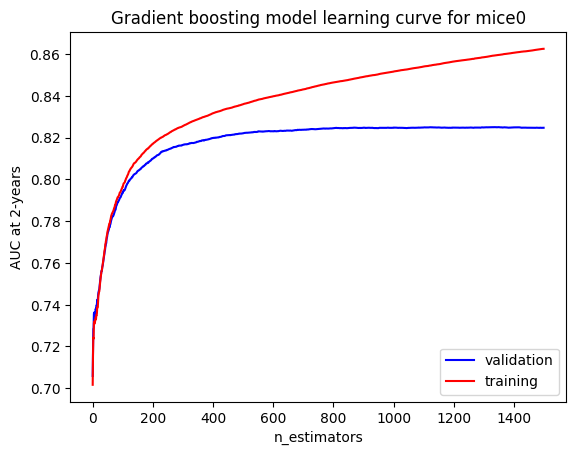

In [123]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm0_staged_auc))
plt.plot(x, gbm0_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm0_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice0')

plt.show()

In [124]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm0_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm0_staged_auc[x:x+24]))

In [125]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm0_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm0_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 800
Validation dataset AUC before degrading: 0.8244870501007124
Training dataset AUC before degrading: 0.8463848274932819


In [126]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 800,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train_mice0_x, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3167
max_resources_: 25341
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 3167
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 6334
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 12668
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 25336
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('std_scaler',
                                                                                                                                            StandardScaler())]),
                                                                                                                           ['age',
                                                                                                 

In [127]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 3,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.75}

**The above best tree depth and subsample will be used for all models moving forward mainly due to the computational cost of searching for these parameters (5-8 hours) for each MICE training set. It also seems likely that these two hyperparamters have small impact on test set AUC performance and are unlikely to change by much for each training set.** 

#### Building model and assessing performance 

In [130]:
gbm_mice0 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 800,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice0.fit(train_mice0_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98545.1015          18.5574          106.57m
         2       98521.4580          18.0374          106.25m
         3       98953.7518          16.0514          106.25m
         4       98544.0712          16.2876          106.11m
         5       98389.3027          15.0766          106.00m
         6       98057.0793          14.8153          105.88m
         7       98320.7863          15.5513          105.72m
         8       98398.7399          13.5435          105.59m
         9       98233.6841          13.2613          105.48m
        10       98433.3780          12.6204          105.34m
        20       98081.6279           8.6935          103.92m
        30       97487.0143           6.2313          102.36m
        40       97233.9694           6.0115          100.91m
        50       97271.9929           5.0812           99.51m
        60       96877.6252           4.9542           98.19m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [131]:
dump(gbm_mice0, 'gbm_mice0.joblib') 

['gbm_mice0.joblib']

In [132]:
gbm_risk_scores_te = gbm_mice0.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.818599164973877


In [133]:
gbm_risk_scores_tr = gbm_mice0.predict(train_mice0_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8429523627339449


In [134]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [135]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002716064313000588


In [136]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [137]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0028578250786696307


In [138]:
mice_auc_data = {'mice_dataset': ['mice_0'],
                 'auc_2yr_te': [gbm_auc_te],
                 'sem_te': [standard_error_te],
                 'auc_2yr_tr': [gbm_auc_tr],
                 'sem_tr': [standard_error_tr]}

mice_auc_df = pd.DataFrame(mice_auc_data)

In [139]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.818599,0.002716,0.842952,0.002858


In [140]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [141]:
times = np.arange(30, 1810, 30)
mice0_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice0_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice_auc_over5 = pd.DataFrame(times_data, index = ['mice_0'])

In [142]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867955,0.88039,0.866605,0.864227,0.863859,0.854639,0.854417,0.853316,0.8527,0.851303,...,0.778385,0.775766,0.776796,0.776186,0.775049,0.774079,0.772508,0.771148,0.771418,0.771102


In [143]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [144]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice0_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 167
Number of non-zero features in final model: 145


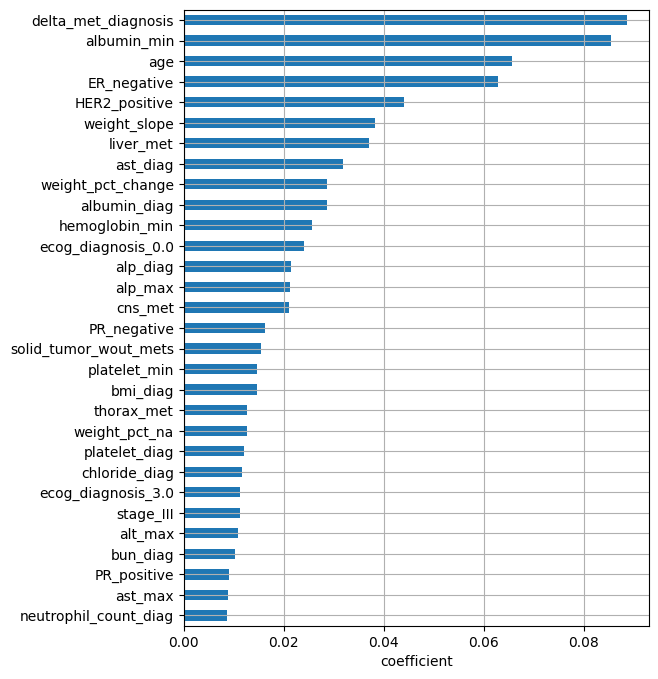

In [145]:
# Dataframe of coefficients for each variable 
coefficients_mice0 = pd.DataFrame(
    gbm_mice0.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice0.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice0.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [146]:
coefficients_mice = (
    coefficients_mice0
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [147]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.2 Model 1

#### Preprocessing and building pipeline 

In [148]:
# Import second training set
train_mice1 = pd.read_csv('mice_tr1.csv', index_col = 'PatientID')

In [149]:
print(train_mice1.shape)

(25341, 183)


In [150]:
train_mice1.isna().sum().sum()

0

In [151]:
train_mice1 = train_mice1.drop(columns = mice_drop)

In [152]:
train_mice1 = train_mice1.drop(columns = dem_var)

In [153]:
print(train_mice1.shape)
print(test_mice.shape)

(25341, 134)
(31680, 136)


In [154]:
train_mice1['ecog_na'] = np.where(train_mice1.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice1['stage_na'] = np.where(train_mice1.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [155]:
for x in list(to_be_categorical):
    train_mice1[x] = train_mice1[x].astype('category')
    
list(train_mice1.select_dtypes(include = ['category']).columns)

['gender',
 'p_type',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis']

In [156]:
train_mice1['death_status'] = train_mice1['death_status'].astype('bool')

In [157]:
val_mice1 = train_mice1[train_mice1.index.isin(val_IDs['PatientID'])]

sub_train_mice1 = train_mice1[~train_mice1.index.isin(val_IDs['PatientID'])]

In [158]:
print(train_mice1.shape)
print(sub_train_mice1.shape)
print(val_mice1.shape)

(25341, 136)
(19005, 136)
(6336, 136)


In [159]:
train_mice1_x = train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice1_x = sub_train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

val_mice1_x = val_mice1.drop(columns = ['death_status', 'timerisk_activity'])

In [160]:
print(train_mice1_x.shape)
print(sub_train_mice1_x.shape)
print(val_mice1_x.shape)

(25341, 134)
(19005, 134)
(6336, 134)


#### Hyperparameter tuning 

In [161]:
sub_train_mice1_xt = preprocessor_red.fit_transform(sub_train_mice1_x)
val_mice1_xt = preprocessor_red.transform(val_mice1_x)

gbm_mice1_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice1_exp.fit(sub_train_mice1_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71485.9658          13.4573          112.14m
         2       71593.5165          12.2227          112.08m
         3       71428.9035          13.2987          111.98m
         4       71121.8733          12.2438          111.88m
         5       71453.2600          11.1170          111.78m
         6       71503.4929          11.3502          111.72m
         7       71187.3431          10.7582          111.65m
         8       71116.9145          10.5685          111.58m
         9       71256.7269          10.0192          111.50m
        10       71395.0230           9.2322          111.40m
        20       70247.6737           6.6271          110.58m
        30       70401.1601           5.6439          109.80m
        40       70193.4396           4.2421          109.02m
        50       70354.0559           3.4131          108.27m
        60       70237.6339           2.9405          107.50m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [162]:
gbm1_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice1_exp.staged_predict(val_mice1_xt)]

In [163]:
gbm1_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice1_exp.staged_predict(sub_train_mice1_xt)]

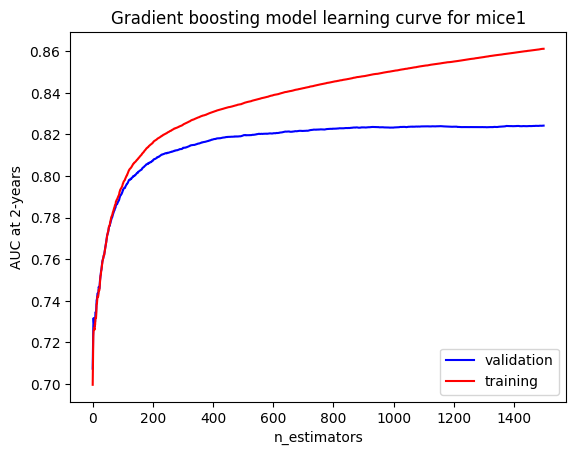

In [164]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm1_staged_auc))
plt.plot(x, gbm1_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm1_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice1')

plt.show()

In [165]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm1_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm1_staged_auc[x:x+24]))

In [166]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm1_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm1_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 925
Validation dataset AUC before degrading: 0.8234900086001695
Training dataset AUC before degrading: 0.8486524068655446


#### Building model and assessing performance 

In [167]:
gbm_mice1 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice1.fit(train_mice1_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98544.4085          18.9917          124.09m
         2       98520.8573          18.0886          123.97m
         3       98954.5505          16.1965          123.80m
         4       98546.3033          17.0248          123.70m
         5       98389.6361          15.2639          123.57m
         6       98058.5205          15.1773          123.44m
         7       98320.2639          15.4625          123.32m
         8       98397.3684          13.1749          123.17m
         9       98231.9655          13.5623          123.02m
        10       98432.2045          13.1568          122.90m
        20       98083.1393           9.1182          121.53m
        30       97494.3609           6.8972          120.19m
        40       97239.7290           6.5868          118.83m
        50       97278.6554           5.2515          117.49m
        60       96886.4625           4.7045          116.14m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [168]:
dump(gbm_mice1, 'gbm_mice1.joblib') 

['gbm_mice1.joblib']

In [169]:
gbm_risk_scores_te = gbm_mice1.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.8186474251897432


In [170]:
gbm_risk_scores_tr = gbm_mice1.predict(train_mice1_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8440038548039918


In [171]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [172]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0027261278864742036


In [173]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [174]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002832915691885077


In [175]:
mice_auc_data = {'mice_dataset': 'mice_1',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [176]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.818599,0.002716,0.842952,0.002858
1,mice_1,0.818647,0.002726,0.844004,0.002833


In [177]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [178]:
times = np.arange(30, 1810, 30)
mice1_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice1_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice1_auc_over5_df = pd.DataFrame(times_data, index = ['mice_1'])

mice_auc_over5 = mice_auc_over5.append(mice1_auc_over5_df, ignore_index = False)

In [179]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867955,0.880390,0.866605,0.864227,0.863859,0.854639,0.854417,0.853316,0.852700,0.851303,...,0.778385,0.775766,0.776796,0.776186,0.775049,0.774079,0.772508,0.771148,0.771418,0.771102
mice_1,0.873185,0.881568,0.868053,0.863218,0.862351,0.852522,0.852056,0.850988,0.851339,0.849721,...,0.778810,0.776321,0.777201,0.777090,0.775756,0.775352,0.773732,0.772719,0.772544,0.772195


In [180]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [181]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice1_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 167
Number of non-zero features in final model: 153


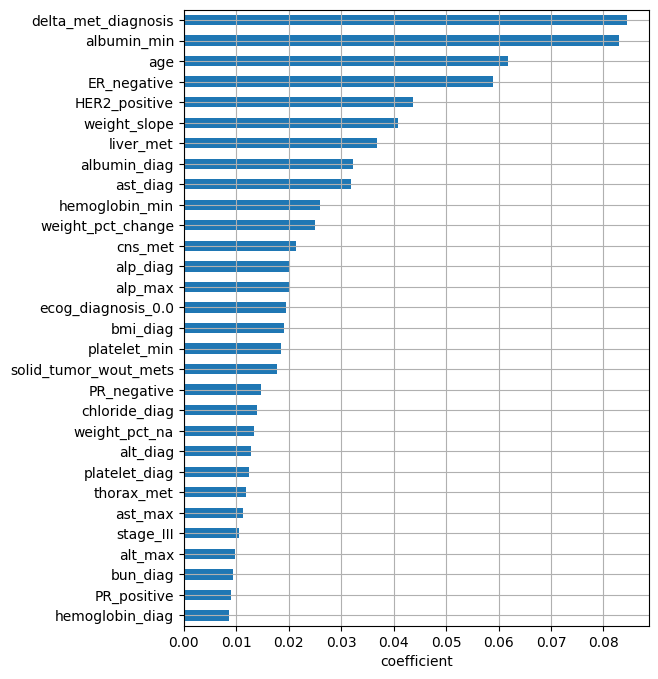

In [182]:
# Dataframe of coefficients for each variable 
coefficients_mice1 = pd.DataFrame(
    gbm_mice1.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice1.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice1.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [183]:
coefficients_mice1_df = (
    coefficients_mice1
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [184]:
coefficients_mice = coefficients_mice.append(coefficients_mice1_df, ignore_index = True)

In [185]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.3 Model 3

#### Preprocessing 

In [186]:
train_mice2 = pd.read_csv('mice_tr2.csv', index_col = 'PatientID')

In [187]:
print(train_mice2.shape)

(25341, 183)


In [188]:
train_mice2.isna().sum().sum()

0

In [189]:
train_mice2 = train_mice2.drop(columns = mice_drop)

In [190]:
train_mice2 = train_mice2.drop(columns = dem_var)

In [191]:
print(train_mice2.shape)

(25341, 134)


In [192]:
train_mice2['ecog_na'] = np.where(train_mice2.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice2['stage_na'] = np.where(train_mice2.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [193]:
for x in list(to_be_categorical):
    train_mice2[x] = train_mice2[x].astype('category')
    
list(train_mice2.select_dtypes(include = ['category']).columns)

['gender',
 'p_type',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis']

In [194]:
train_mice2['death_status'] = train_mice2['death_status'].astype('bool')

In [195]:
val_mice2 = train_mice2[train_mice2.index.isin(val_IDs['PatientID'])]

sub_train_mice2 = train_mice2[~train_mice2.index.isin(val_IDs['PatientID'])]

In [196]:
print(train_mice2.shape)
print(sub_train_mice2.shape)
print(val_mice2.shape)

(25341, 136)
(19005, 136)
(6336, 136)


In [197]:
train_mice2_x = train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice2_x = sub_train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

val_mice2_x = val_mice2.drop(columns = ['death_status', 'timerisk_activity'])

In [198]:
print(train_mice2_x.shape)
print(sub_train_mice2_x.shape)
print(val_mice2_x.shape)

(25341, 134)
(19005, 134)
(6336, 134)


#### Hyperparameter tuning 

In [199]:
sub_train_mice2_xt = preprocessor_red.fit_transform(sub_train_mice2_x)
val_mice2_xt = preprocessor_red.transform(val_mice2_x)

gbm_mice2_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice2_exp.fit(sub_train_mice2_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71487.6303          12.6050          112.77m
         2       71596.1642          12.5891          112.51m
         3       71432.7581          12.2278          112.38m
         4       71123.6703          11.2126          112.27m
         5       71459.0793          10.4635          112.19m
         6       71510.6289          11.1274          112.10m
         7       71197.7567          10.3350          112.00m
         8       71124.1426          10.0790          111.90m
         9       71269.3389          10.1430          111.81m
        10       71408.9659           8.7319          111.71m
        20       70260.9747           6.9570          110.85m
        30       70419.0875           5.2138          110.06m
        40       70202.0897           5.0799          109.27m
        50       70360.1563           2.8518          108.49m
        60       70246.9100           3.8266          107.72m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [200]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice2_exp.staged_predict(val_mice2_xt)]

In [201]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice2_exp.staged_predict(sub_train_mice2_xt)]

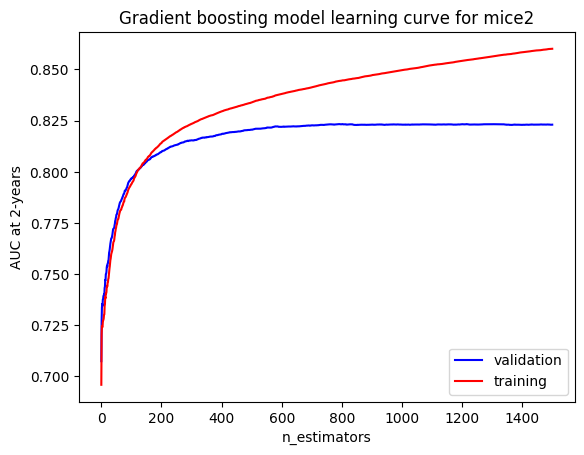

In [202]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice2')

plt.show()

In [203]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [204]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 575
Validation dataset AUC before degrading: 0.821970006007128
Training dataset AUC before degrading: 0.8369910739095661


#### Building model and assessing performance

In [205]:
gbm_mice2 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice2.fit(train_mice2_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98546.5892          18.2658           76.57m
         2       98525.3587          17.4195           76.46m
         3       98962.5924          15.2840           76.35m
         4       98552.6569          16.1056           76.24m
         5       98399.1008          14.9401           76.13m
         6       98067.8298          14.6589           75.97m
         7       98332.2656          14.8349           75.85m
         8       98410.2250          13.1917           75.72m
         9       98246.1910          13.0764           75.58m
        10       98448.3742          13.1612           75.46m
        20       98094.5506           9.0767           74.12m
        30       97510.1280           6.8891           72.80m
        40       97250.1425           6.6741           71.46m
        50       97284.4151           4.8799           70.13m
        60       96886.2570           4.7324           68.79m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [206]:
dump(gbm_mice2, 'gbm_mice2.joblib') 

['gbm_mice2.joblib']

In [207]:
gbm_risk_scores_te = gbm_mice2.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 year:', gbm_auc_te)

Test set AUC at 2 year: 0.8160362844929341


In [208]:
gbm_risk_scores_tr = gbm_mice2.predict(train_mice2_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 year:', gbm_auc_tr)

Training set AUC at 2 year: 0.8337725788181732


In [209]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [210]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002730237341199098


In [211]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [212]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0029115248366738933


In [213]:
mice_auc_data = {'mice_dataset': 'mice_2',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [214]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.818599,0.002716,0.842952,0.002858
1,mice_1,0.818647,0.002726,0.844004,0.002833
2,mice_2,0.816036,0.002730,0.833773,0.002912


In [215]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [216]:
times = np.arange(30, 1810, 30)
mice2_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice2_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice2_auc_over5_df = pd.DataFrame(times_data, index = ['mice_2'])

mice_auc_over5 = mice_auc_over5.append(mice2_auc_over5_df, ignore_index = False)

In [217]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867955,0.880390,0.866605,0.864227,0.863859,0.854639,0.854417,0.853316,0.852700,0.851303,...,0.778385,0.775766,0.776796,0.776186,0.775049,0.774079,0.772508,0.771148,0.771418,0.771102
mice_1,0.873185,0.881568,0.868053,0.863218,0.862351,0.852522,0.852056,0.850988,0.851339,0.849721,...,0.778810,0.776321,0.777201,0.777090,0.775756,0.775352,0.773732,0.772719,0.772544,0.772195
mice_2,0.861207,0.873302,0.860786,0.858488,0.858254,0.850145,0.849208,0.848321,0.848794,0.848070,...,0.779464,0.776718,0.778167,0.777555,0.776343,0.775126,0.773948,0.772909,0.773169,0.772923


In [218]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [219]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice2_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 167
Number of non-zero features in final model: 134


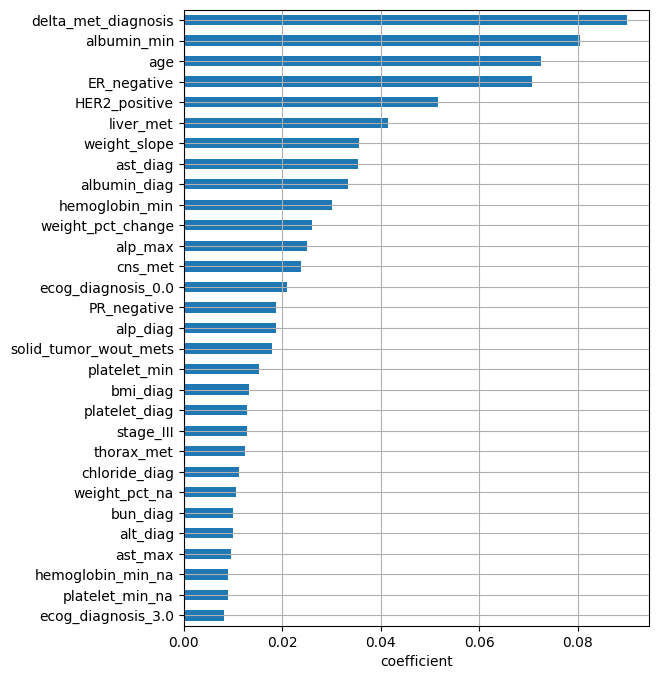

In [220]:
# Dataframe of coefficients for each variable 
coefficients_mice2 = pd.DataFrame(
    gbm_mice2.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice2.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice2.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [221]:
coefficients_mice2_df = (
    coefficients_mice2
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [222]:
coefficients_mice = coefficients_mice.append(coefficients_mice2_df, ignore_index = True)

In [223]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.4 Model 4

#### Preprocessing 

In [224]:
train_mice3 = pd.read_csv('mice_tr3.csv', index_col = 'PatientID')

In [225]:
print(train_mice3.shape)

(25341, 183)


In [226]:
train_mice3.isna().sum().sum()

0

In [227]:
train_mice3 = train_mice3.drop(columns = mice_drop)

In [228]:
train_mice3 = train_mice3.drop(columns = dem_var)

In [229]:
print(train_mice3.shape)

(25341, 134)


In [230]:
train_mice3['ecog_na'] = np.where(train_mice3.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice3['stage_na'] = np.where(train_mice3.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [231]:
for x in list(to_be_categorical):
    train_mice3[x] = train_mice3[x].astype('category')
    
list(train_mice3.select_dtypes(include = ['category']).columns)

['gender',
 'p_type',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis']

In [232]:
train_mice3['death_status'] = train_mice3['death_status'].astype('bool')

In [233]:
val_mice3 = train_mice3[train_mice3.index.isin(val_IDs['PatientID'])]

sub_train_mice3 = train_mice3[~train_mice3.index.isin(val_IDs['PatientID'])]

In [234]:
print(train_mice3.shape)
print(sub_train_mice3.shape)
print(val_mice3.shape)

(25341, 136)
(19005, 136)
(6336, 136)


In [235]:
train_mice3_x = train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice3_x = sub_train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

val_mice3_x = val_mice3.drop(columns = ['death_status', 'timerisk_activity'])

In [236]:
print(train_mice3_x.shape)
print(sub_train_mice3_x.shape)
print(val_mice3_x.shape)

(25341, 134)
(19005, 134)
(6336, 134)


#### Hyperparameter tuning 

In [237]:
sub_train_mice3_xt = preprocessor_red.fit_transform(sub_train_mice3_x)
val_mice3_xt = preprocessor_red.transform(val_mice3_x)

gbm_mice3_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice3_exp.fit(sub_train_mice3_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71487.1372          13.1683          111.76m
         2       71594.8085          12.6776          111.72m
         3       71431.3903          12.2168          111.63m
         4       71123.7753          11.3298          111.58m
         5       71460.1305          11.2493          111.50m
         6       71509.7119          10.6436          111.40m
         7       71195.6926          10.2322          111.35m
         8       71121.5146          10.0960          111.29m
         9       71265.6876           9.7813          111.20m
        10       71403.2799           9.3466          111.15m
        20       70255.6520           6.3737          110.40m
        30       70409.1592           5.9580          109.63m
        40       70196.6327           5.4847          108.90m
        50       70346.9013           3.9457          108.14m
        60       70239.4570           2.9340          107.37m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [238]:
gbm3_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice3_exp.staged_predict(val_mice3_xt)]

In [239]:
gbm3_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice3_exp.staged_predict(sub_train_mice3_xt)]

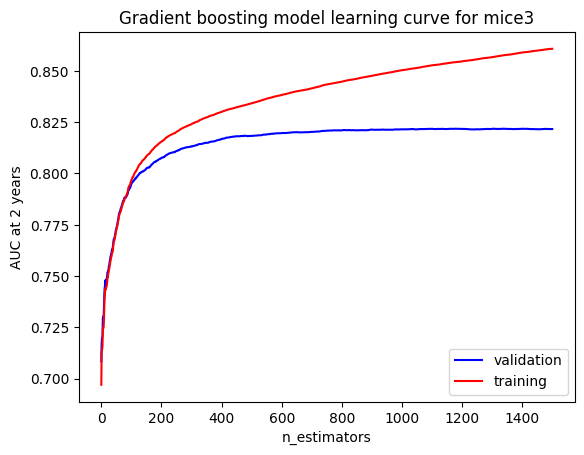

In [240]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm3_staged_auc))
plt.plot(x, gbm3_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm3_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice3')

plt.show()

In [241]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm3_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm3_staged_auc[x:x+24]))

In [242]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm3_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm3_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 800
Validation dataset AUC before degrading: 0.8210382666939581
Training dataset AUC before degrading: 0.8447333765186245


#### Model building and performance assessment 

In [243]:
gbm_mice3 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice3.fit(train_mice3_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98546.5750          18.8776          105.55m
         2       98523.2631          17.7704          105.46m
         3       98956.6380          15.7510          105.40m
         4       98547.8096          16.4378          105.34m
         5       98393.0430          15.1374          105.25m
         6       98062.8777          15.1358          105.15m
         7       98327.3063          15.0242          105.05m
         8       98403.7583          13.1895          104.92m
         9       98238.0474          11.5308          104.79m
        10       98441.5910          12.6531          104.64m
        20       98078.7826           8.7007          103.26m
        30       97491.9212           7.3820          101.93m
        40       97245.8604           6.6649          100.59m
        50       97262.0625           6.3501           99.26m
        60       96874.7283           5.2812           97.93m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [244]:
dump(gbm_mice3, 'gbm_mice3.joblib') 

['gbm_mice3.joblib']

In [245]:
gbm_risk_scores_te = gbm_mice3.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.8182987047737824


In [246]:
gbm_risk_scores_tr = gbm_mice3.predict(train_mice3_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8409841060387127


In [247]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [248]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002716671116168675


In [249]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [250]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0028767726940999295


In [251]:
mice_auc_data = {'mice_dataset': 'mice_3',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [252]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.818599,0.002716,0.842952,0.002858
1,mice_1,0.818647,0.002726,0.844004,0.002833
2,mice_2,0.816036,0.002730,0.833773,0.002912
3,mice_3,0.818299,0.002717,0.840984,0.002877


In [253]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [254]:
times = np.arange(30, 1810, 30)
mice3_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice3_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice3_auc_over5_df = pd.DataFrame(times_data, index = ['mice_3'])

mice_auc_over5 = mice_auc_over5.append(mice3_auc_over5_df, ignore_index = False)

In [255]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867955,0.880390,0.866605,0.864227,0.863859,0.854639,0.854417,0.853316,0.852700,0.851303,...,0.778385,0.775766,0.776796,0.776186,0.775049,0.774079,0.772508,0.771148,0.771418,0.771102
mice_1,0.873185,0.881568,0.868053,0.863218,0.862351,0.852522,0.852056,0.850988,0.851339,0.849721,...,0.778810,0.776321,0.777201,0.777090,0.775756,0.775352,0.773732,0.772719,0.772544,0.772195
mice_2,0.861207,0.873302,0.860786,0.858488,0.858254,0.850145,0.849208,0.848321,0.848794,0.848070,...,0.779464,0.776718,0.778167,0.777555,0.776343,0.775126,0.773948,0.772909,0.773169,0.772923
mice_3,0.869425,0.879509,0.865788,0.862427,0.861947,0.852748,0.851926,0.850881,0.850605,0.849665,...,0.779605,0.776872,0.777866,0.777208,0.775989,0.774956,0.773481,0.772173,0.772416,0.772410


In [256]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [257]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice3_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 167
Number of non-zero features in final model: 150


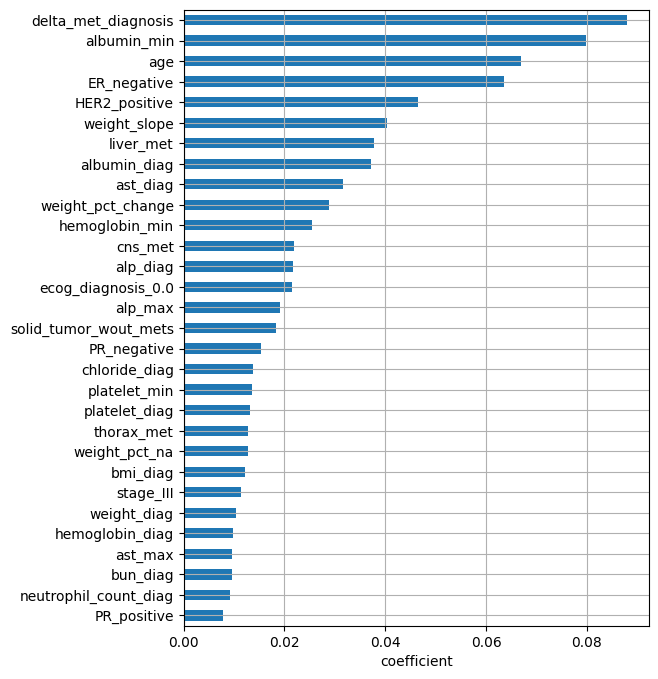

In [258]:
# Dataframe of coefficients for each variable 
coefficients_mice3 = pd.DataFrame(
    gbm_mice3.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice3.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice3.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [259]:
coefficients_mice3_df = (
    coefficients_mice3
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [260]:
coefficients_mice = coefficients_mice.append(coefficients_mice3_df, ignore_index = True)

In [261]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.5 Model 5

#### Preprocessing

In [262]:
train_mice4 = pd.read_csv('mice_tr4.csv', index_col = 'PatientID')

In [263]:
train_mice4.shape

(25341, 183)

In [264]:
train_mice4.isna().sum().sum()

0

In [265]:
train_mice4 = train_mice4.drop(columns = mice_drop)

In [266]:
train_mice4 = train_mice4.drop(columns = dem_var)

In [267]:
print(train_mice4.shape)

(25341, 134)


In [268]:
train_mice4['ecog_na'] = np.where(train_mice4.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice4['stage_na'] = np.where(train_mice4.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [269]:
for x in list(to_be_categorical):
    train_mice4[x] = train_mice4[x].astype('category')
    
list(train_mice4.select_dtypes(include = ['category']).columns)

['gender',
 'p_type',
 'stage',
 'met_year',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'ecog_diagnosis']

In [270]:
train_mice4['death_status'] = train_mice4['death_status'].astype('bool')

In [271]:
val_mice4 = train_mice4[train_mice4.index.isin(val_IDs['PatientID'])]

sub_train_mice4 = train_mice4[~train_mice4.index.isin(val_IDs['PatientID'])]

In [272]:
print(train_mice4.shape)
print(sub_train_mice4.shape)
print(val_mice4.shape)

(25341, 136)
(19005, 136)
(6336, 136)


In [273]:
train_mice4_x = train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice4_x = sub_train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

val_mice4_x = val_mice4.drop(columns = ['death_status', 'timerisk_activity'])

In [274]:
print(train_mice4_x.shape)
print(sub_train_mice4_x.shape)
print(val_mice4_x.shape)

(25341, 134)
(19005, 134)
(6336, 134)


#### Hyperparameter tuning

In [275]:
sub_train_mice4_xt = preprocessor_red.fit_transform(sub_train_mice4_x)
val_mice4_xt = preprocessor_red.transform(val_mice4_x)

gbm_mice4_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice4_exp.fit(sub_train_mice4_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       71486.9902          12.8640          112.40m
         2       71595.3323          13.0733          112.09m
         3       71430.6120          12.3747          111.97m
         4       71121.3746          11.1122          111.86m
         5       71458.4512          11.3430          111.77m
         6       71507.1235          10.6966          111.65m
         7       71191.9083          10.5565          111.56m
         8       71120.2803           9.7116          111.46m
         9       71261.5327          10.1777          111.38m
        10       71400.2879           9.5074          111.25m
        20       70251.7436           7.3283          110.43m
        30       70406.8312           6.3055          109.66m
        40       70182.7240           4.9372          108.90m
        50       70342.7406           3.4882          108.15m
        60       70226.9788           3.0996          107.40m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [276]:
gbm4_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice4_exp.staged_predict(val_mice4_xt)]

In [277]:
gbm4_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice4_exp.staged_predict(sub_train_mice4_xt)]

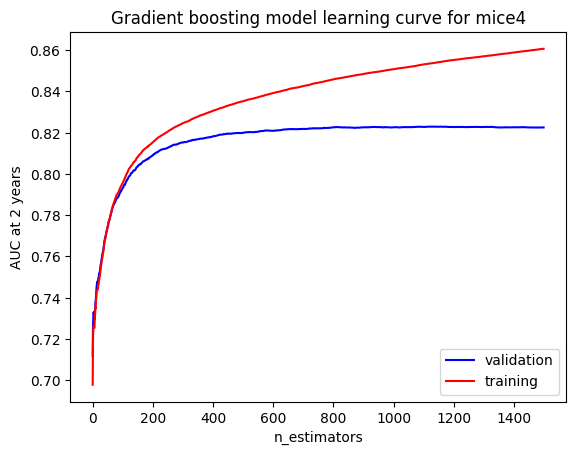

In [278]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm4_staged_auc))
plt.plot(x, gbm4_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm4_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice4')

plt.show()

In [279]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm4_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm4_staged_auc[x:x+24]))

In [280]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm4_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm4_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 800
Validation dataset AUC before degrading: 0.8226087847665118
Training dataset AUC before degrading: 0.84587039372735


#### Model building and performance asssessment 

In [281]:
print(train_mice4_x.shape)
print(train_y.shape)

(25341, 134)
(25341,)


In [282]:
gbm_mice4 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice4.fit(train_mice4_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       98545.9641          18.8303          106.77m
         2       98523.4398          17.5303          106.72m
         3       98958.5043          15.8802          106.60m
         4       98550.3140          16.4061          106.47m
         5       98394.3994          14.7734          106.33m
         6       98065.2782          14.8592          106.19m
         7       98329.6977          15.3393          106.05m
         8       98401.1209          12.6645          105.92m
         9       98238.4421          12.3726          105.77m
        10       98442.9627          12.8750          105.66m
        20       98082.7965           8.4486          104.31m
        30       97492.3741           7.1359          102.99m
        40       97242.9541           6.3152          101.63m
        50       97262.6001           5.3696          100.29m
        60       96872.2112           4.7718           98.98m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [283]:
dump(gbm_mice4, 'gbm_mice4.joblib') 

['gbm_mice4.joblib']

In [284]:
gbm_risk_scores_te = gbm_mice4.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.8176334016782112


In [285]:
gbm_risk_scores_tr = gbm_mice4.predict(train_mice4_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8413757841447188


In [286]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [287]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0027265638210085077


In [288]:
# Bootstrap 10000 2 yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [289]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0028647212818947963


In [290]:
mice_auc_data = {'mice_dataset': 'mice_4',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [291]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.818599,0.002716,0.842952,0.002858
1,mice_1,0.818647,0.002726,0.844004,0.002833
2,mice_2,0.816036,0.002730,0.833773,0.002912
3,mice_3,0.818299,0.002717,0.840984,0.002877
4,mice_4,0.817633,0.002727,0.841376,0.002865


In [292]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [293]:
times = np.arange(30, 1810, 30)
mice4_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice4_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice4_auc_over5_df = pd.DataFrame(times_data, index = ['mice_4'])

mice_auc_over5 = mice_auc_over5.append(mice4_auc_over5_df, ignore_index = False)

In [294]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.867955,0.880390,0.866605,0.864227,0.863859,0.854639,0.854417,0.853316,0.852700,0.851303,...,0.778385,0.775766,0.776796,0.776186,0.775049,0.774079,0.772508,0.771148,0.771418,0.771102
mice_1,0.873185,0.881568,0.868053,0.863218,0.862351,0.852522,0.852056,0.850988,0.851339,0.849721,...,0.778810,0.776321,0.777201,0.777090,0.775756,0.775352,0.773732,0.772719,0.772544,0.772195
mice_2,0.861207,0.873302,0.860786,0.858488,0.858254,0.850145,0.849208,0.848321,0.848794,0.848070,...,0.779464,0.776718,0.778167,0.777555,0.776343,0.775126,0.773948,0.772909,0.773169,0.772923
mice_3,0.869425,0.879509,0.865788,0.862427,0.861947,0.852748,0.851926,0.850881,0.850605,0.849665,...,0.779605,0.776872,0.777866,0.777208,0.775989,0.774956,0.773481,0.772173,0.772416,0.772410
mice_4,0.867958,0.878845,0.866174,0.863355,0.862380,0.852478,0.851895,0.850944,0.850314,0.849388,...,0.778533,0.775873,0.776784,0.776400,0.775235,0.774013,0.772469,0.771556,0.771711,0.771504


In [295]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [296]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice4_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 167
Number of non-zero features in final model: 141


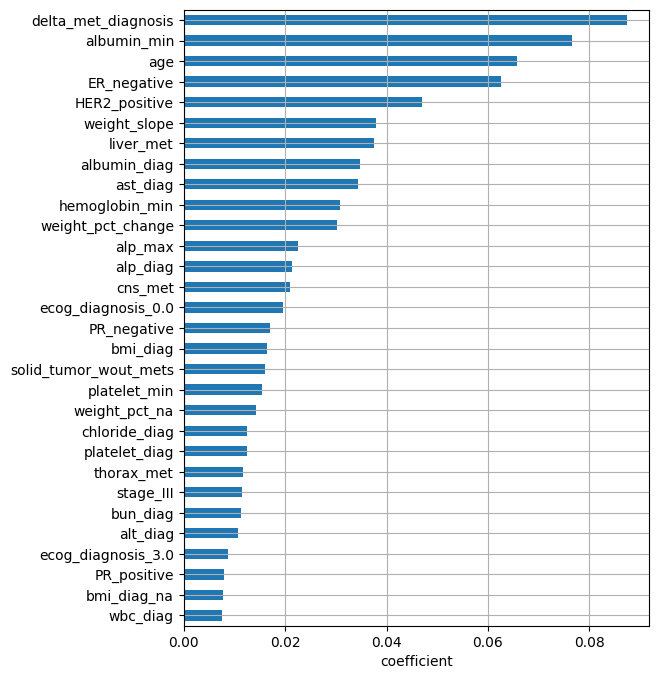

In [297]:
# Dataframe of coefficients for each variable 
coefficients_mice4 = pd.DataFrame(
    gbm_mice4.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice4.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice4.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [298]:
coefficients_mice4_df = (
    coefficients_mice4
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [299]:
coefficients_mice = coefficients_mice.append(coefficients_mice4_df, ignore_index = True)

In [300]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### Part 4. Pooling results

#### 4.1 Pooling AUC

In [301]:
from math import sqrt, exp 
from scipy.stats import t

**Test and training AUCs will be pooled using Rubin’s rules. This is complicated by the fact that AUCs are bounded and thus not normally distributed. The AUCs will therefore be logit transformed to an unbounded scale, then Rubin's rules will be applied to these values, and finally they will be back-transformed into a final pool estimate.** 

In [302]:
# This function is translated from the R package: "psfmi: Prediction Model Selection and Performance Evaluation in
# Multiple Imputed Datasets"

def pool_auc(auc_arr, se_arr, iterations_n):
    
    # pooled SE using Rubin's rules 
    def rr_se(est, se, iterations_n):
        m = iterations_n
        w_auc = np.mean(np.square(se)) # within variance 
        b_auc = np.var(est) # between variance 
        tv_auc = w_auc + (1 + (1/m)) * b_auc # total vairance 
        se_total = sqrt(tv_auc)
        r = (1 + (1/ m)) * (b_auc / w_auc)
        v = (m - 1) * (1 + (1/r))**2
        w = t.ppf(0.975, v) # Percent point function or inverse CDF with df = v
        res = np.array([se_total, w])
        return(res)
    
    # log transform
    auc_log = np.log(auc_arr / (1-auc_arr))
    se_log = se_arr / (auc_arr * (1-auc_arr))
    
    # input log transfomred auc and se to calculat RR's total se
    se_total = rr_se(auc_log, se_log, iterations_n = iterations_n)
    
    # backtransform 
    inv_auc = exp(np.mean(auc_log)) / (1 + exp(np.mean(auc_log)))
    inv_auc_upper = exp(np.mean(auc_log) + (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) + (se_total[1]*se_total[0])))
    inv_auc_lower = exp(np.mean(auc_log) - (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) - (se_total[1]*se_total[0])))
    sem = (inv_auc_upper - inv_auc_lower) / 3.92
    auc_res = np.round(np.array([inv_auc_lower, inv_auc, inv_auc_upper, sem]), 6)
    return(auc_res)

In [303]:
mice_auc_df = pd.read_csv('mice_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                      'sem_te': np.float64,
                                                      'auc_2yr_tr': np.float64,
                                                      'sem_tr': np.float64})

In [304]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.818599,0.002716,0.842952,0.002858
1,mice_1,0.818647,0.002726,0.844004,0.002833
2,mice_2,0.816036,0.002730,0.833773,0.002912
3,mice_3,0.818299,0.002717,0.840984,0.002877
4,mice_4,0.817633,0.002727,0.841376,0.002865


In [305]:
pool_auc_test = pool_auc(mice_auc_df['auc_2yr_te'].values, 
                         mice_auc_df['sem_te'].values, 
                         5)

print(pool_auc_test)

[0.812014 0.817845 0.823535 0.002939]


In [306]:
pool_auc_train = pool_auc(mice_auc_df['auc_2yr_tr'].values,
                          mice_auc_df['sem_tr'].values,
                          5)

print(pool_auc_train)

[0.829499 0.84065  0.851202 0.005536]


In [307]:
crude_auc_df = pd.read_csv('crude_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                        'sem_te': np.float64,
                                                        'auc_2yr_tr': np.float64,
                                                        'sem_tr': np.float64})

In [308]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.814230,0.006072,0.850084,0.002805
1,rsf_crude,0.795440,0.006377,0.883202,0.002398
2,ridge_crude,0.782643,0.006584,0.784937,0.003340
3,lasso_crude,0.783386,0.006583,0.785551,0.003348
4,enet_crude,0.783361,0.006578,0.785536,0.003336
5,linear_svm_crude,0.785235,0.006473,0.790172,0.003294


In [309]:
mice_auc_data = {'model': 'gbm_mice',
                 'auc_2yr_te': pool_auc_test[1],
                 'sem_te': pool_auc_test[3],
                 'auc_2yr_tr': pool_auc_train[1],
                 'sem_tr': pool_auc_train[3]}

In [310]:
ml_auc_df = crude_auc_df.append(mice_auc_data, ignore_index = True)

In [311]:
ml_auc_df.sort_values(by = 'auc_2yr_te', ascending = False)

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
6,gbm_mice,0.817845,0.002939,0.840650,0.005536
0,gbm_crude,0.814230,0.006072,0.850084,0.002805
1,rsf_crude,0.795440,0.006377,0.883202,0.002398
5,linear_svm_crude,0.785235,0.006473,0.790172,0.003294
3,lasso_crude,0.783386,0.006583,0.785551,0.003348
4,enet_crude,0.783361,0.006578,0.785536,0.003336
2,ridge_crude,0.782643,0.006584,0.784937,0.003340


In [312]:
ml_auc_df.to_csv('ml_auc_df.csv', index = False, header = True)